### 0. Importing modules and data

In [309]:
import pandas as pd
from edastatmil_milser import edas_tatmil as EDA
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pickle import dump
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [310]:
raw_df = pd.read_csv('../data/raw/sales.csv')
raw_df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [311]:
raw_df.tail(1)

,date,sales
365,2023-09-03 17:10:08.079328,1000.482785


### 0.1 Transform date column

In [312]:
raw_df['date'] = pd.to_datetime(raw_df['date'])
raw_df.set_index('date', inplace=True)

### 0.2 Visualization

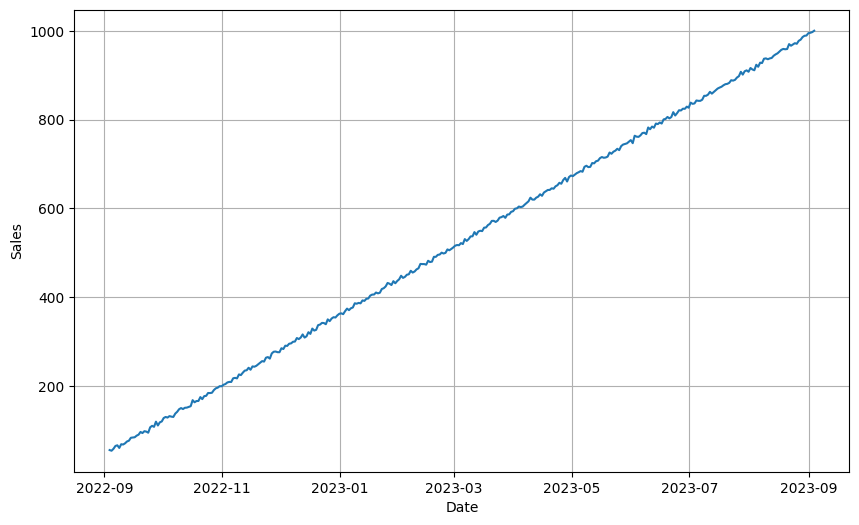

In [313]:
plt.figure(figsize=(10, 6))
plt.plot(raw_df)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)

### 1. Stadistical evaluation
#### 1.1 Tensor
The minimum time unit for which there is data is one day. Therefore, the tensor is for one day. We make de decomposition with n=30days
#### 1.2 Trend
The trend is linear and increasing.
#### 1.3 Seasonality

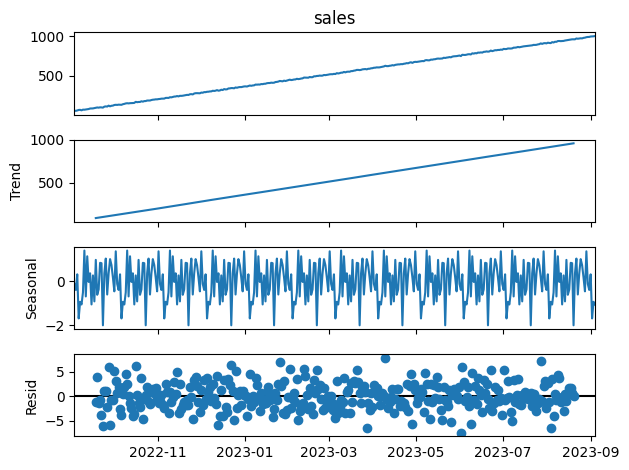

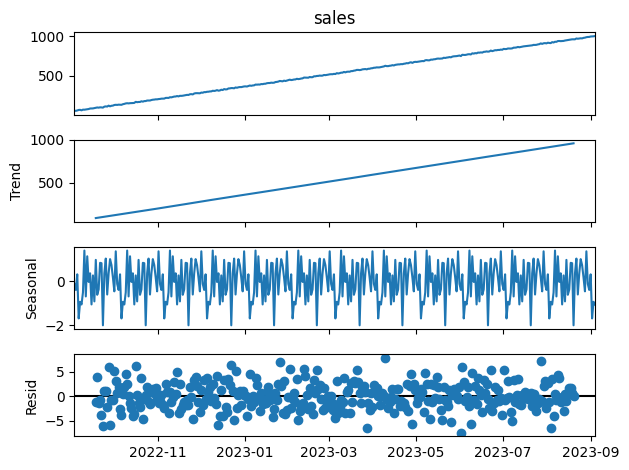

In [314]:
result = seasonal_decompose(raw_df['sales'], model='additive', period=30)
result.plot()

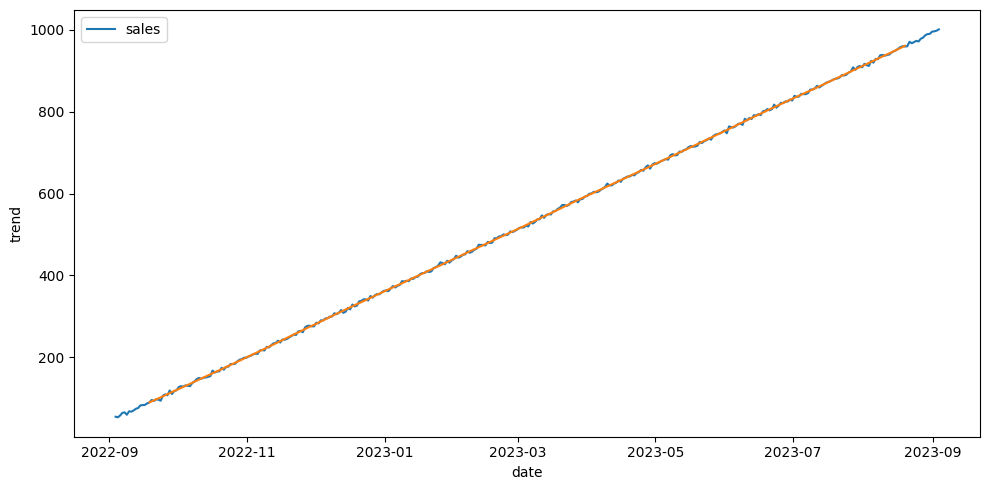

In [315]:
trend = result.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(raw_df)
sns.lineplot(data = trend)

plt.tight_layout()

In [316]:
adf_result = adfuller(raw_df['sales'])
print('Dickey-Fuller:')
print(f'p-value: {adf_result[1]}')
print('Result:')
print('The series is stationary.' if adf_result[1] < 0.05 else 'The series is not stationary.')


Dickey-Fuller:
p-value: 0.9861899815311068
Result:
The series is not stationary.


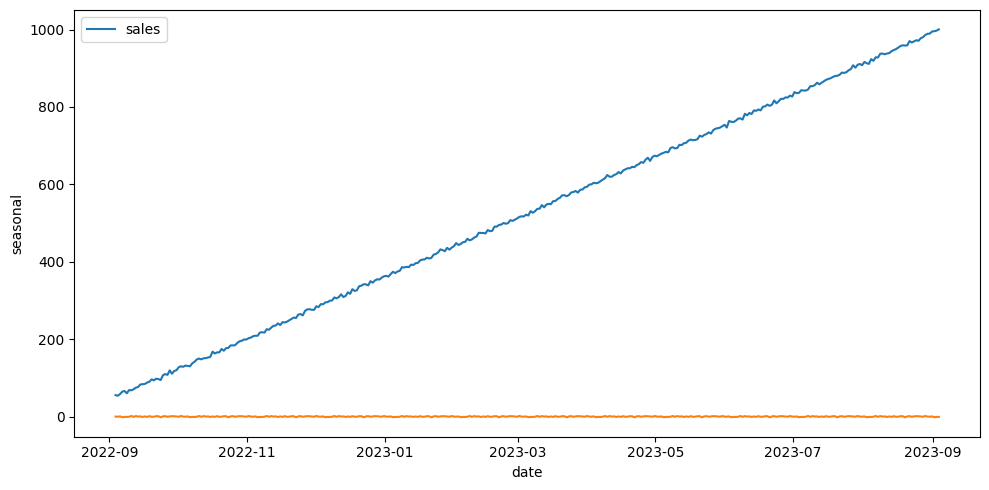

In [317]:
seasonal = result.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = raw_df)
sns.lineplot(data = seasonal)

plt.tight_layout()

The series is not stationary.

#### 1.4 Variability

Residuals standard deviation: 2.7210214123965297


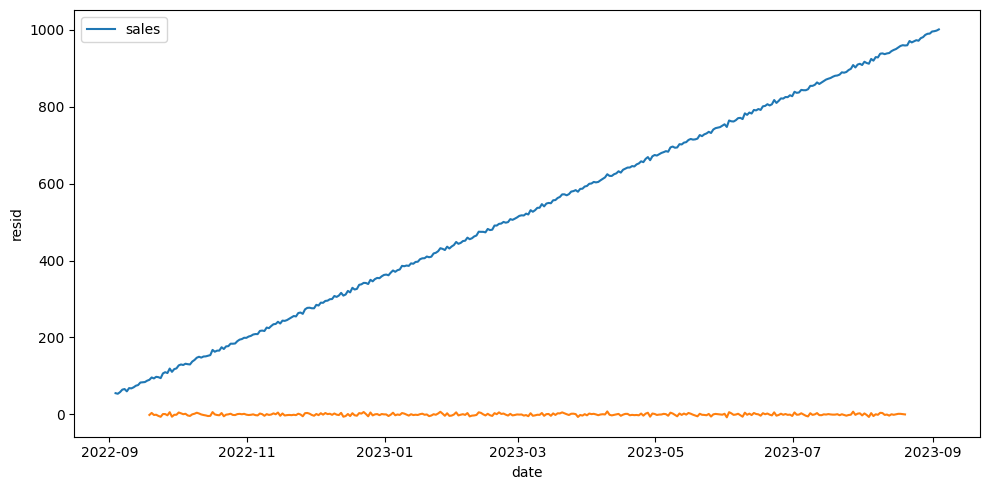

In [318]:
residuals = result.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = raw_df)
sns.lineplot(data = residuals)

plt.tight_layout()

std_dev_residuals = residuals.std()
print(f'Residuals standard deviation: {std_dev_residuals}')

There is no so much variability in sales data.

### 2. ARIMA

Since this temporal series is not stationary, we have to make transform it.

In [319]:
df_stationary = raw_df.diff().dropna()
df_stationary.to_csv('../data/processed/Sales_St.csv')

ADF_result = adfuller(df_stationary['sales'])
print('Dickey-Fuller:')
print(f'p-value: {ADF_result[1]}')
print('Result:')
print('The series is stationary.' if ADF_result[1] < 0.05 else 'The series is not stationary.')

Dickey-Fuller:
p-value: 5.212954111417141e-16
Result:
The series is stationary.


In [320]:
model = auto_arima(df_stationary, seasonal = True, trace = True, m = 30)

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=1845.252, Time=14.84 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=2096.542, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=1971.739, Time=1.93 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=inf, Time=5.98 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=2209.657, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[30] intercept   : AIC=1843.274, Time=9.20 sec
 ARIMA(2,0,2)(0,0,0)[30] intercept   : AIC=1843.048, Time=1.00 sec
 ARIMA(2,0,2)(1,0,0)[30] intercept   : AIC=1843.220, Time=10.49 sec
 ARIMA(1,0,2)(0,0,0)[30] intercept   : AIC=1843.587, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[30] intercept   : AIC=1841.533, Time=0.76 sec
 ARIMA(2,0,1)(1,0,0)[30] intercept   : AIC=1921.468, Time=6.18 sec
 ARIMA(2,0,1)(0,0,1)[30] intercept   : AIC=1841.423, Time=28.57 sec
 ARIMA(2,0,1)(1,0,1)[30] intercept   : AIC=inf, Time=19.36 sec
 ARIMA(2,0,1)(0,0,2)[30] intercept   : AIC=1843.425, Time=37.53 sec
 ARIMA(2,0,1)(1,0,2)[30] intercept   : AIC=inf, Time=42.09 sec
 ARI

In [321]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  365
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 30)   Log Likelihood                -914.720
Date:                            Fri, 03 May 2024   AIC                           1839.439
Time:                                    22:07:15   BIC                           1858.939
Sample:                                09-04-2022   HQIC                          1847.188
                                     - 09-03-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8192      0.134     20.987      0.000       2.556       3.083
ar.L1         -0.0850      0.052     -1.642      0.101      -0.187       0.016
ma.L1         -0.9435      0.020    -47.194      0.000      -0.983      -0.904
ma.S.L30      -0.0806      0.061     -1.323      0.186      -0.200       0.039
sigma2         8.7304      0.683     12.788      0.000       7.392      10.068
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              0.99   Prob(JB):                         0.68
Heteroskedasticity (H):               0.92   Skew:                             0.07
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 2.1 Prediction

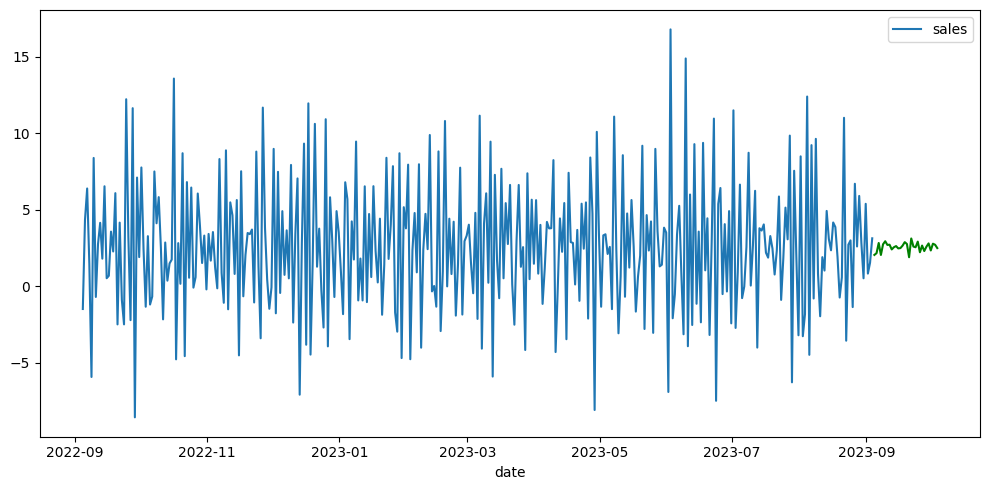

In [322]:
forecast = model.predict(30)
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df_stationary)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

In [323]:

dump(model, open("../data/processed/Models/ARIMA_30.sav", "wb"))